In [1]:
!pip install -U torchdata==0.5.1
!pip install -Uqq portalocker==2.7.0
!pip install -qq torchtext==0.16.0
!pip install -Uq nltk==3.8.1
# !pip install wordsegment
!pip install underthesea
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 48.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 73.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.7 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 2.5.0.post0 requires torch>=2.1.0, but you have torch 1.13.1 which is incompatible.
torchaudio 2.5.1+cu121 

# Set up

## Import Modules/Libraries

In [4]:
import torch
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from torch import Tensor
import torch.nn as nn
from torch.nn import Transformer
import math
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from underthesea import word_tokenize
#import re
import pandas as pd
import json
from torchtext.vocab import Vocab
import time
#from wordsegment import load, segment
import json

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# Read Data

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hungnm/englishvietnamese-translation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/englishvietnamese-translation


In [6]:
en_dir = '/kaggle/input/englishvietnamese-translation/en_sents'
vi_dir = '/kaggle/input/englishvietnamese-translation/vi_sents'

# read data in files
with open(en_dir, 'r', encoding='utf-8') as f:
    en_data = f.read().splitlines()

with open(vi_dir, 'r', encoding='utf-8') as f:
    vi_data = f.read().splitlines()

df = pd.DataFrame({'en': en_data, 'vi': vi_data})
df.head()

,en,vi
0,Please put the dustpan in the broom closet,xin vui lòng đặt người quét rác trong tủ chổi
1,Be quiet for a moment.,im lặng một lát
2,Read this,đọc này
3,Tom persuaded the store manager to give him ba...,tom thuyết phục người quản lý cửa hàng trả lại...
4,Friendship consists of mutual understanding,tình bạn bao gồm sự hiểu biết lẫn nhau


check both datasets have same len or not

In [7]:
len(en_data), len(vi_data)

(254090, 254090)

In [8]:
import pandas as pd
import re

# Hàm tiền xử lý
def preprocessing(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'([^\w\s])', r' \1 ', text)  # Separate punctuation from words
    text = text.strip()  # Trim leading and trailing spaces
    return text

df["en"] = df["en"].astype(str).apply(preprocessing)
df["vi"] = df["vi"].astype(str).apply(preprocessing)

In [9]:
from torch.utils.data import random_split

dataset_size = len(df)
train_ratio = 0.9 
train_size = int(train_ratio * dataset_size)
valid_size = dataset_size - train_size

# Chia dữ liệu ngẫu nhiên
train_indices, valid_indices = random_split(df.index.tolist(), [train_size, valid_size])

# Lấy danh sách index từ Subset
train_indices = train_indices.indices
valid_indices = valid_indices.indices

# Tạo DataFrame mới
df_train = df.iloc[train_indices].copy()
df_valid = df.iloc[valid_indices].copy()

df_train = list(zip(df_train['en'], df_train['vi']))
df_valid = list(zip(df_valid['en'], df_valid['vi']))
print(len(df_train))

228681


## Build Vocab

In [10]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'vi'

en_text = df['en']
vi_text = df['vi']

def vi_tokenizer(sentence):
    tokens = word_tokenize(sentence)
    return tokens

vocab_transform = {}
token_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('basic_english')
token_transform[TGT_LANGUAGE] = get_tokenizer(vi_tokenizer)

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [ ]:
import os
import json

def yield_tokens(data_iter: Iterable, language: str):
    count = 0
    start_time = time.time()
    for data_sample in data_iter:
        if count % 50000 == 0:
            print(f"Processed {count} samples {language} in {time.time() - start_time:.2f} seconds")
            start_time = time.time()
        count += 1
        yield token_transform[language](data_sample)

for text, ln in zip([en_text, vi_text], [SRC_LANGUAGE, TGT_LANGUAGE]):
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(text, ln),
                                                     min_freq=1,
                                                     specials=special_symbols,
                                                     special_first=True)

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)


In [11]:
from torchtext.vocab import vocab as torch_vocab
from collections import Counter

vocab_transform = {}
def load_vocab(path):
    with open(path, "r", encoding="utf-8") as f:
        vocab_dict = json.load(f)

    # Tạo Counter với min_freq=1 để giữ thứ tự từ
    counter = Counter({word: 1 for word in vocab_dict["itos"]})

    new_vocab = torch_vocab(counter, specials=special_symbols, special_first=True)

    new_vocab.itos = vocab_dict["itos"]
    
    return new_vocab

vocab_transform["en"] = load_vocab("/kaggle/input/vocab/vocab_en.json")
vocab_transform["vi"] = load_vocab("/kaggle/input/vocab/vocab_vi.json")
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

print(vocab_transform["en"].get_itos()[:10]) 

# ['<unk>', '<pad>', '<bos>', '<eos>', '.', "'", 'i', 'the', 'to', 'tom']

['<unk>', '<pad>', '<bos>', '<eos>', '.', "'", 'i', 'the', 'to', 'tom']


In [12]:
len(vocab_transform[SRC_LANGUAGE])

20059

## Utils

For using Dataloader with Dataframe, convert it to Dataset to pytorch understand

In [12]:
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def tensor_transform(token_ids):
    return torch.cat((torch.tensor([BOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX])))

text_transform = {
    SRC_LANGUAGE: sequential_transforms(token_transform[SRC_LANGUAGE], vocab_transform[SRC_LANGUAGE], tensor_transform),
    TGT_LANGUAGE: sequential_transforms(token_transform[TGT_LANGUAGE], vocab_transform[TGT_LANGUAGE], tensor_transform)
}

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)

    return src_batch, tgt_batch


def index_to_en(seq_en):
    return " ".join([vocab_transform['en'].get_itos()[int(index)] for index in seq_en.flatten()])

def index_to_vi(seq_vi):
    return " ".join([vocab_transform['vi'].get_itos()[int(index)] for index in seq_vi.flatten()])

In [13]:
en, vi = df_train[2]
en_collate = text_transform[SRC_LANGUAGE](en.rstrip("\n"))
vi_collate = text_transform[TGT_LANGUAGE](vi.rstrip("\n"))

en_pad = pad_sequence([en_collate], batch_first=True, padding_value=PAD_IDX)
vi_pad = pad_sequence([vi_collate], batch_first=True, padding_value=PAD_IDX)

In [14]:
print("vi input")
print(index_to_vi(vi_pad))
print("english target")
print(index_to_en(en_pad))
print("_________\n")

vi input
<bos> mary nghỉ thai sản . <eos>
english target
<bos> mary took maternity leave . <eos>
_________



## Masking


In [15]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
def generate_square_subsequent_mask(sz, device=DEVICE):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [17]:
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Positional Encoding

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float = 0.1,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

## Token Embedding

In [19]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

## Transformer Architecture

In [20]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()

        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)

        # Chuyển generator sang DEVICE
        self.generator.to(DEVICE)

        # Khởi tạo trọng số
        self._init_parameters()

    def _init_parameters(self):
        for p in self.transformer.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

## Inference

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20240729154418/Transformer.png">


In [21]:
torch.manual_seed(0)
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8  
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
DROP_OUT = 0.1

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM, DROP_OUT)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [22]:
transformer.load_state_dict(torch.load('/kaggle/input/transformer-10epochs/transformer_en_to_vi_model_10_epoches.pt', map_location=DEVICE, ))

<All keys matched successfully>

In [28]:
train_dataloader = DataLoader(df_train, batch_size=1, collate_fn=collate_fn)

In [48]:
for i, (src, tgt) in enumerate(train_dataloader):
    print(f"{i+1}th sample")
    print(f"english: {index_to_en(src)}")
    print(f"vietnamese: {index_to_vi(tgt)}")
    num_tokens = src.shape[0]
    print("-------------")
    break

num_tokens 

1th sample
english: <bos> what did he do to you ? <eos>
vietnamese: <bos> anh ta đã làm gì bạn ? <eos>
-------------


9

You can construct a mask to delineate which inputs are factored into the attention computation. Given that this pertains to a translation task, all tokens in the source sequence are accessible, thus setting the mask values to `false`.


In [42]:
src_mask = torch.zeros(num_tokens, num_tokens).type(torch.bool).to(DEVICE )
src_mask[0:10]

tensor([[False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False]])



Extract the first sample from the batch of sequences slated for translation. While currently redundant, this procedure will become relevant later as you handle larger batches.


In [53]:
src_ = src[:, 0].unsqueeze(1)
print(src_.shape)
print(src.shape)

torch.Size([9, 1])
torch.Size([9, 1])


Feed the tokens of the sequences designated for translation into the transformer, accompanied by the mask. The resultant values, stored in the 'memory', are the embeddings derived from the output of the transformer encoder as shown in the following image:

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/Transformersencoder.png" alt="trasfoemr">

The memory, which is the encoder's output, encapsulates the original sequence to be translated and serves as the input for the decoder.


In [54]:
memory = transformer.encode(src_, src_mask)
memory.shape # (len, batch, embed_size)

torch.Size([9, 1, 512])

 To indicate the beginning of an output sequence generation, initiate it with the start symbol:


In [55]:
ys = torch.ones(1, 1).fill_(BOS_IDX).type(torch.long).to(DEVICE)
ys

tensor([[2]])

Due to some naming conventions, the term "target" is used to denote the prediction. In this context, the "target" refers to the words following the current prediction. These can be combined with the source to make further predictions. Consequently, you construct a target mask set to 'false' indicating that no values should be ignored:


In [56]:
tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
tgt_mask

tensor([[False]])

You feed the encoder's output (referred to as 'memory') and the previous prediction from the transformer, which at this point is solely the start token, into the decoder:


In [57]:
out = transformer.decode(ys, memory, tgt_mask)
out.shape # (batch_size, seq_len, d_model)

torch.Size([1, 1, 512])

In [58]:
out = out.transpose(0, 1)
out.shape

torch.Size([1, 1, 512])

In [59]:
logit = transformer.generator(out[:, -1])
logit.shape

torch.Size([1, 15112])

The process is succinctly illustrated in the image below:

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/decoder_start.png" alt="trasfoemr">



The predicted word is determined by identifying the highest logit value, which signifies the model's most probable translation for the input at a specific position; this position corresponds to the index of the next token.


In [61]:
  _, next_word_index = torch.max(logit, dim=1)

In [63]:
print("engish output:",index_to_en(next_word_index))

engish output: i


You only need the integer for the index:


In [64]:
next_word_index=next_word_index.item()
next_word_index

6

Now, append the newly predicted word to the prior predictions, allowing the model to consider the entire sequence of generated words when making its next prediction.


In [65]:
ys = torch.cat([ys,torch.ones(1, 1).type_as(src.data).fill_(next_word_index)], dim=0)
ys

tensor([[2],
        [6]])

In [37]:
accumulation_steps = 5

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    val_los = 0
    train_dataloader = DataLoader(df_train, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    optimizer.zero_grad() 
    for i, (src, tgt) in enumerate(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)   
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss = loss / accumulation_steps # Normalize our loss to avoid overfit and not overload gpu efficiency usage
        loss.backward()
        
        if (i+1) % accumulation_steps == 0:            
            optimizer.step()
            optimizer.zero_grad() 

        losses += loss.item()

    return losses / len(train_dataloader)

def evaluate(model):
    model.eval()
    losses = 0
    #val_iter = valid.iterrows()
    val_dataloader = DataLoader(df_valid, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss = loss / accumulation_steps # Normalize our loss to avoid overfit and not overload gpu efficiency usage
        losses += loss.item()

    return losses / len(val_dataloader)

In [38]:
class early_stopping:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.early_stop = False

    def __call__(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [39]:
import torch
from timeit import default_timer as timer

NUM_EPOCHS = 30
history = {
    "train_loss": [],
    "val_loss": []
}

best_val_loss = float("inf") 

early_stop = early_stopping(patience=3, min_delta=0)

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    
    print(f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Epoch time = {(end_time - start_time):.3f}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        print(f'best_epoch: {best_epoch} with val_loss: {best_val_loss}')
        torch.save(transformer.state_dict(), 'best_transformer_checkpoint.pt')

    early_stop(val_loss)
    if early_stop.early_stop:
        print("training stopping early")
        break

torch.save(transformer.state_dict(), 'transformer_en_to_vi_model_30_epochs.pt')


Epoch: 1, Train loss: 0.824, Val loss: 0.597, Epoch time = 367.099s
best_epoch: 1 with val_loss: 0.596973413685758
Epoch: 2, Train loss: 0.558, Val loss: 0.461, Epoch time = 368.219s
best_epoch: 2 with val_loss: 0.46128066760211733
Epoch: 3, Train loss: 0.454, Val loss: 0.386, Epoch time = 374.281s
best_epoch: 3 with val_loss: 0.385512652184496
Epoch: 4, Train loss: 0.388, Val loss: 0.336, Epoch time = 374.087s
best_epoch: 4 with val_loss: 0.33613888427952127
Epoch: 5, Train loss: 0.342, Val loss: 0.303, Epoch time = 371.886s
best_epoch: 5 with val_loss: 0.3026836388112612
Epoch: 6, Train loss: 0.307, Val loss: 0.278, Epoch time = 368.991s
best_epoch: 6 with val_loss: 0.2783216435237596
Epoch: 7, Train loss: 0.280, Val loss: 0.258, Epoch time = 368.602s
best_epoch: 7 with val_loss: 0.2583843147634861
Epoch: 8, Train loss: 0.258, Val loss: 0.243, Epoch time = 369.271s
best_epoch: 8 with val_loss: 0.24299804765225655
Epoch: 9, Train loss: 0.240, Val loss: 0.231, Epoch time = 369.385s
bes

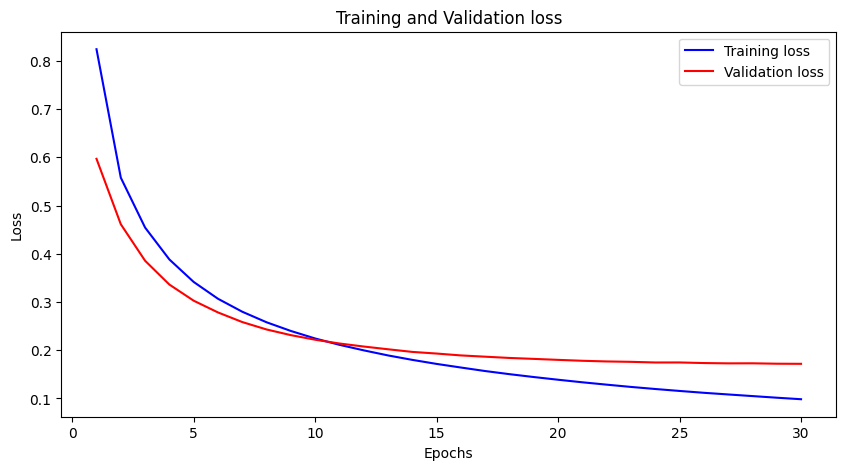

In [42]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, history['train_loss'], 'b', label='Training loss')
plt.plot(epochs, history['val_loss'], 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Translation and evaluation 
Using the greedy_decode function that you defined earlier, you can create a translator function that generates English translation of an input German text.


In [78]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

In [79]:
# translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 10, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [45]:
val_dataloader = DataLoader(df_valid, batch_size=1, collate_fn=collate_fn)

In [46]:
for i, (src, tgt) in enumerate(val_dataloader):
    
    print(f"{i}th sample")
    print("German Sentence:",index_to_en(src).replace("<bos>", "").replace("<eos>", ""))
    print("English Translation:",index_to_vi(tgt).replace("<bos>", "").replace("<eos>", ""))
    print("Model Translation:",translate(transformer,index_to_en(src)))
    print("_________\n")
    if i == 10:
        break

0th sample
German Sentence:  if you keep practicing , you ' ll soon get the feel of it 
English Translation:  nếu bạn tiếp tục luyện tập , bạn sẽ sớm cảm nhận được nó 
Model Translation:  nếu bạn tiếp tục tập tin , bạn sẽ cảm thấy 
_________

1th sample
German Sentence:  participation is voluntary and free of charge . 
English Translation:  tham gia là tự nguyện và miễn phí . 
Model Translation:  phí là miễn phí . 
_________

2th sample
German Sentence:  here are the rules . 
English Translation:  đây là các quy tắc . 
Model Translation:  các quy tắc đây 
_________

3th sample
German Sentence:  that sounds like tom 
English Translation:  nghe giống tom 
Model Translation:  nghe có vẻ như tom 
_________

4th sample
German Sentence:  he didn ' t have a single pen 
English Translation:  anh ấy không có một cây bút 
Model Translation:  anh ấy không có bút 
_________

5th sample
German Sentence:  my father bought me a digital watch for birthday present . 
English Translation:  cha tôi đã mu

In [80]:
input_text = input("Input text:... ")
print(translate(transformer, index_to_en(text_transform['en'](input_text))))

Input text:...  Even though time has passed, my feelings remain the same.


 mặc dù vẫn có nhiều thời gian , cảm xúc của tôi 


## Evaluation with BLEU score
To evaluate the generated translations, a function calculate_bleu_score is introduced. It computes the BLEU score, a common metric for machine translation quality, by comparing the generated translation to reference translations. The BLEU score provides a quantitative measure of translation accuracy.

The code also includes an example of calculating the BLEU score for a generated translation.


In [47]:
def calculate_bleu_score(generated_translation, reference_translations):
    # convert the generated translations and reference translations into the expected format for sentence_bleu
    references = [reference.split() for reference in reference_translations]
    hypothesis = generated_translation.split()

    # calculate the BLEU score
    bleu_score = sentence_bleu(references, hypothesis)

    return bleu_score

In [48]:
generated_translation = translate(transformer,"A brown dog is playing in the snow .")

reference_translations = [
    "1 con chó nâu đang chơi với tuyết",
    "1 con chó nâu chơi đùa với tuyết",
    "1 con chó nâu đang nằm trên tuyết",
    "trong tuyết có 1 con chó nâu đang chơi đùa"
]

bleu_score = calculate_bleu_score(generated_translation, reference_translations)
print("BLEU Score:", bleu_score, "cho",generated_translation)

BLEU Score: 5.423660437707094e-78 cho  một con chó màu nâu đang chơi trong tuyết . 


## Save Vocab

In [ ]:



def save_vocab(vocab, dir_path, file_name):
    os.makedirs(dir_path, exist_ok=True)  
    file_path = os.path.join(dir_path, file_name)

    vocab_dict = {
        "itos": vocab.get_itos(), 
    }

    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(vocab_dict, f, ensure_ascii=False, indent=4)

    print(f"Saved vocab to {file_path}")

# Lưu từ vựng vào thư mục 'vocab_data'
save_vocab(vocab_transform["en"], "/kaggle/working/vocab_data", "vocab_en.json")
save_vocab(vocab_transform["vi"], "/kaggle/working/vocab_data", "vocab_vi.json")
